In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('C:/Users/User/kaggle/GoDaddy'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from tqdm.auto import tqdm

import datetime
import dateutil.parser

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

%matplotlib inline

import plotly.express as px

import copy
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from statsmodels.tsa.forecasting.stl import STLForecast, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing as ES

import xgboost as xgb
import statsmodels.formula.api as smf

C:/Users/User/kaggle/GoDaddy\ACSST5Y2017.S0101-Column-Metadata.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2017.S0101-Data.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2018.S0101-Column-Metadata.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2018.S0101-Data.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2019.S0101-Column-Metadata.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2019.S0101-Data.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2020.S0101-Column-Metadata.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2020.S0101-Data.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2021.S0101-Column-Metadata.csv
C:/Users/User/kaggle/GoDaddy\ACSST5Y2021.S0101-Data.csv
C:/Users/User/kaggle/GoDaddy\best_jan_sub_20230314.csv
C:/Users/User/kaggle/GoDaddy\census_starter.csv
C:/Users/User/kaggle/GoDaddy\cfips_location.csv
C:/Users/User/kaggle/GoDaddy\county-neighbours.csv
C:/Users/User/kaggle/GoDaddy\laucnty00.xlsx
C:/Users/User/kaggle/GoDaddy\laucnty01.xlsx
C:/Users/User/kaggle/GoDaddy\laucnty02.xlsx
C:/Users/User/kaggle/GoDaddy\laucnty03.xlsx
C:/User

In [2]:
def smape(y_true, y_pred):
    
    # CONVERT TO NUMPY
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def vsmape(y_true, y_pred):
    
    # CONVERT TO NUMPY
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1
    y_pred[idx]=1
    
    return 200 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))

### Load Data

In [3]:
train_data = pd.read_csv('C:/Users/User/kaggle/GoDaddy/train.csv')
test_data = pd.read_csv('C:/Users/User/kaggle/GoDaddy/test.csv')
revealed_data = pd.read_csv('C:/Users/User/kaggle/GoDaddy/revealed_test.csv')

In [4]:
train_data['is_test'] = 0
revealed_data['is_test'] = 1
test_data['is_test'] = 2

test_data = test_data[~test_data.row_id.isin(revealed_data.row_id)]

data = pd.concat([train_data, revealed_data, test_data])

data['first_day_of_month'] = pd.to_datetime(data['first_day_of_month'])

data['month_from_month'] =data['first_day_of_month'].dt.month
data['year_from_month'] =data['first_day_of_month'].dt.year

data['population_year_minus_two']=(data['active']/data['microbusiness_density'])*100
data['population_year'] = data.year_from_month - 2

coords = pd.read_csv('C:/Users/User/kaggle/GoDaddy/cfips_location.csv', sep=',')
data = data.merge(coords.drop(['name'], axis=1), on="cfips", how="left")

for cfips in tqdm(data['cfips'].unique()):
    mask = data.cfips == cfips
    data.loc[mask, 'county'] = data.loc[mask, 'county'].iloc[0]
    data.loc[mask, 'state'] = data.loc[mask, 'state'].iloc[0]
    data.loc[mask, 'population_year_minus_two'] = data.loc[mask, 'population_year_minus_two'].ffill()


data.reset_index(drop=True, inplace=True)

  0%|          | 0/3135 [00:00<?, ?it/s]

Things we tried but didn't work: Latitude and Longitude Transforms: TODO: Insert link to notebook
I was excited to learn about the UMAP transform library, however I found it did not improve the score other than the already in place latitude and longitude

Add the actual population data
Again, special thanks to Chris Deotte for uploading this data.

In [5]:
for year in data['population_year'].unique():
    print(f'Processing {year}')
    filename = f'C:/Users/User/kaggle/GoDaddy/ACSST5Y{year}.S0101-Data.csv'
    COLS = ['GEO_ID','NAME','S0101_C01_026E', 'S0101_C01_028E']
    temp = pd.read_csv(filename,usecols=COLS)
    temp = temp.iloc[1:]
    temp['S0101_C01_026E'] = temp['S0101_C01_026E'].astype('int')
    temp['S0101_C01_028E'] = temp['S0101_C01_028E'].astype('int')
    temp['cfips'] = temp.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
    adult = temp.set_index('cfips').S0101_C01_026E.to_dict()
    retired = temp.set_index('cfips').S0101_C01_028E.to_dict()
    mask = data.population_year == year
    data.loc[mask, 'used_population'] = data.loc[mask, 'cfips'].map(adult)
    data.loc[mask, 'retired_population'] = data.loc[mask, 'cfips'].map(retired)

C:\Users\User\AppData\Local\Temp\ipykernel_41848\2225007560.py:5: DtypeWarning: Columns (102,110) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(filename,usecols=COLS)


Processing 2017
Processing 2018


C:\Users\User\AppData\Local\Temp\ipykernel_41848\2225007560.py:5: DtypeWarning: Columns (102,110) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(filename,usecols=COLS)
C:\Users\User\AppData\Local\Temp\ipykernel_41848\2225007560.py:5: DtypeWarning: Columns (102,110) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(filename,usecols=COLS)


Processing 2019
Processing 2020


C:\Users\User\AppData\Local\Temp\ipykernel_41848\2225007560.py:5: DtypeWarning: Columns (102,110) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(filename,usecols=COLS)


Processing 2021


C:\Users\User\AppData\Local\Temp\ipykernel_41848\2225007560.py:5: DtypeWarning: Columns (102,110) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(filename,usecols=COLS)


Add the census data
Many models that acheived high scores had a look ahead bias in that they would use the pct_bb_2021 as a predictor in the cross validation. I have chosen to just use the last available census data to prevent this. It is lagged by 2 years.

In [6]:
census_data = pd.read_csv('C:/Users/User/kaggle/GoDaddy/census_starter.csv')
census_data.set_index('cfips', inplace=True)

def add_last_year_data(cfips, year, census_data, col_stub):
    col_name = f"{col_stub}{year}"
    return census_data.loc[cfips][col_name]

data['pct_bb_last_year'] = data.apply(lambda row: add_last_year_data(cfips=row['cfips'], 
                                                                     year=row['population_year'], 
                                                                     census_data=census_data, 
                                                                     col_stub='pct_bb_'), axis=1)
data['pct_college_last_year'] = data.apply(lambda row: add_last_year_data(cfips=row['cfips'], 
                                                                          year=row['population_year'], 
                                                                          census_data=census_data, 
                                                                          col_stub='pct_college_'), axis=1)
data['pct_foreign_born_last_year'] = data.apply(lambda row: add_last_year_data(cfips=row['cfips'], 
                                                                               year=row['population_year'], 
                                                                               census_data=census_data, 
                                                                               col_stub='pct_foreign_born_'), axis=1)
data['pct_it_workers_last_year'] = data.apply(lambda row: add_last_year_data(cfips=row['cfips'], 
                                                                             year=row['population_year'], 
                                                                             census_data=census_data,
                                                                             col_stub='pct_it_workers_'), axis=1)
data['median_hh_inc_last_year'] = data.apply(lambda row: add_last_year_data(cfips=row['cfips'], 
                                                                            year=row['population_year'], 
                                                                            census_data=census_data, 
                                                                            col_stub='median_hh_inc_'), axis=1)

Add neighboring county information
We would assume that any differences relative to neighboring counties would be smoothed out over time for two reasons:

If it is a data error, the nearby counties should have the real value.
If it is a true change, as people move to the area they would spread out to nearby counties for their business.
Special thanks to @pranay for posting the data

In [7]:
def add_neighbor_value(df, weighted=False):
    county_neighbors=pd.read_csv('C:/Users/User/kaggle/GoDaddy/county-neighbours.csv')
    county_neighbors.rename(columns = {'Neighbour county code':'cfips'}, inplace = True)
    
    res = defaultdict(float)
    all_cfips = df['cfips'].unique()
    for cfips in tqdm(all_cfips):
        neighbors = county_neighbors[county_neighbors['Countycode'] == cfips]['cfips'].unique()
        if len(neighbors) == 0:  # If no neighbors, set to self
            tdf = df[df['cfips'] == cfips]
            res.update({(cfips, row['first_day_of_month']): row['microbusiness_density'] for __, row in tdf.iterrows()})
        else:
            temp = df[df['cfips'].isin(neighbors)]

            if not weighted:
                 res.update({(cfips, dt): df['microbusiness_density'].mean() for dt, df in temp.groupby('first_day_of_month')})
            else:
                res.update({(cfips, dt): (df['microbusiness_density'] * df['used_population']).sum() / df['used_population'].sum() for dt, df in temp.groupby('first_day_of_month')})


    df['neighbor_average'] = df.apply(lambda row: res[(row['cfips'], row['first_day_of_month'])], axis=1)
    df['neighbor_diff'] = df['neighbor_average']/df['microbusiness_density'] - 1
    
    df.loc[df['microbusiness_density'] == 0, 'neighbor_diff'] = 0
    
add_neighbor_value(data)

  0%|          | 0/3135 [00:00<?, ?it/s]

Add population changes for many years and population makeup
* Since the target is the active amount of businesses divided by the 2 year lagged working age population, forecasting a population change, if the fraction of microbusinesses is roughly constant, could add some forecasting power.
* The population makeup could also be a predictor

In [8]:
working_age = {5, 6, 7, 8, 9, 10, 11}
pop_df = pd.read_csv('C:/Users/User/kaggle/GoDaddy/us.1969_2020.19ages.adjusted.csv')
total_pop = pop_df.groupby(['Year', 'cfips'])['population'].sum()
working_pop = pop_df[pop_df['agecode'].isin(working_age)].groupby(['Year', 'cfips'])['population'].sum() / total_pop
working_male = pop_df[pop_df['agecode'].isin(working_age) & (pop_df['sex'] == 'M')].groupby(['Year', 'cfips'])['population'].sum() / total_pop
white_pop = pop_df[pop_df['race'] == 'W'].groupby(['Year', 'cfips'])['population'].sum() / total_pop
black_pop = pop_df[pop_df['race'] == 'B'].groupby(['Year', 'cfips'])['population'].sum() / total_pop

In [9]:
def get_pop(row, pop_df_grp, dflt='population_year_minus_two'):
    try:
        return pop_df_grp.loc[row['population_year'], row['cfips']]
    except KeyError:
        return row[dflt]


def get_pop_pct(row, pop_df_grp, dflt=np.nan):
    try:
        return pop_df_grp.loc[row['population_year'], row['cfips']]
    except KeyError:
        return dflt


def get_10yr_pop_chg(row, pop_df_grp):
    try:
        yr = row['population_year']
        now = pop_df_grp.loc[yr, row['cfips']]
        then = pop_df_grp.loc[yr-10, row['cfips']]
        return now / then - 1
    except KeyError:
        return 0

for c in data.columns:
    if 'seer' in c:
        del data[c]
    
data['seer_pop'] = data.apply(lambda row: get_pop(row, total_pop), axis=1)

data['seer_working_pct'] = data.apply(lambda row: get_pop_pct(row, working_pop), axis=1)
data['seer_working_male_pct'] = data.apply(lambda row: get_pop_pct(row, working_male), axis=1)
data['seer_white_pct'] = data.apply(lambda row: get_pop_pct(row, white_pop), axis=1)
data['seer_black_pct'] = data.apply(lambda row: get_pop_pct(row, black_pop), axis=1)

data['seer_pop_chg'] = data.apply(lambda row: get_10yr_pop_chg(row, total_pop), axis=1)
data['seer_pop_ratio'] = data['seer_pop']/data['used_population'] - 1

In [10]:
for cfips in tqdm(data['cfips'].unique()):
    mask = data.cfips == cfips
    for c in data.columns:
        if 'seer' in c:
            data.loc[mask, c] = data.loc[mask, c].ffill()
            
data

  0%|          | 0/3135 [00:00<?, ?it/s]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,is_test,month_from_month,year_from_month,...,median_hh_inc_last_year,neighbor_average,neighbor_diff,seer_pop,seer_working_pct,seer_working_male_pct,seer_white_pct,seer_black_pct,seer_pop_chg,seer_pop_ratio
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,8,2019,...,55317.0,2.192232,-0.271122,55448.000000,0.460738,0.225779,0.779054,0.200729,0.058067,0.335228
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,9,2019,...,55317.0,2.216480,-0.231688,55448.000000,0.460738,0.225779,0.779054,0.200729,0.058067,0.335228
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,10,2019,...,55317.0,2.211303,-0.276369,55448.000000,0.460738,0.225779,0.779054,0.200729,0.058067,0.335228
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,11,2019,...,55317.0,2.212587,-0.260804,55448.000000,0.460738,0.225779,0.779054,0.200729,0.058067,0.335228
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,12,2019,...,55317.0,2.246902,-0.249340,55448.000000,0.460738,0.225779,0.779054,0.200729,0.058067,0.335228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56037_2023-06-01,56037,Sweetwater County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,76668.0,NaN,NaN,32048.999235,0.453448,0.236238,0.951070,0.018185,0.000000,0.016977
147341,56039_2023-06-01,56039,Teton County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,94498.0,NaN,NaN,19163.999680,0.514747,0.272588,0.959952,0.011065,0.000000,-0.000261
147342,56041_2023-06-01,56041,Uinta County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,75106.0,NaN,NaN,14516.000261,0.411971,0.207371,0.964037,0.011031,0.000000,-0.008538
147343,56043_2023-06-01,56043,Washakie County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,62271.0,NaN,NaN,6044.999960,0.380412,0.198840,0.960696,0.011856,0.000000,0.007500


In [11]:
for col in ['unemployment_rate', 'labor_force']:
    full_dict = defaultdict(lambda: np.nan)
    for yr in data['population_year'].unique():
        file = 'C:/Users/User/kaggle/GoDaddy/laucnty{}.xlsx'.format(yr % 100)
        columns = ['LUASCode', 'state_fips', 'county_fips', 'name', 'year', 'dummy', 'labor_force', 'employed', 'unemployed', 'unemployment_rate']
        df = pd.read_excel(file, header=4)
        df.columns = columns
        del df['dummy']
        df.dropna(inplace=True)
        df['year'] = df['year'].map(int)
        df['cfips'] = (df['state_fips']*1000 + df['county_fips']).map(int)
        temp = {(row['cfips'],yr): row[col] for __, row in df.iterrows()}
        full_dict.update(temp)

    data[col] = data.apply(lambda row: full_dict[(row['cfips'], row['population_year'])], axis=1)

In [12]:
for cfips in tqdm(data['cfips'].unique()):
    mask = data.cfips == cfips
    for c in ['unemployment_rate', 'labor_force']:
        data.loc[mask, c] = data.loc[mask, c].ffill()

  0%|          | 0/3135 [00:00<?, ?it/s]

<Axes: >

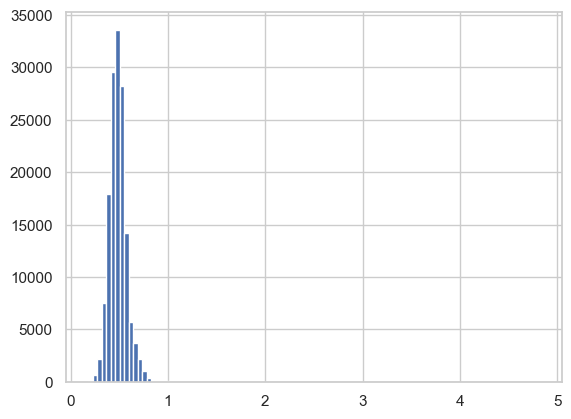

In [13]:
data['labor_participation'] = data['labor_force'] / data['seer_pop']
data['labor_participation'].hist(bins=100)

In [14]:
tmp = pd.read_csv('C:/Users/User/kaggle/GoDaddy/VF_mai_counties_Q222.csv')
tmp['first_day_of_month'] = pd.to_datetime(tmp['date'])
data = data.merge(tmp.drop(['total_pop_20', 'county_name', 'date'], axis=1), how='left', on=['first_day_of_month', 'cfips'])
data

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,is_test,month_from_month,year_from_month,...,seer_black_pct,seer_pop_chg,seer_pop_ratio,unemployment_rate,labor_force,labor_participation,MAI_composite,engagement,participation,infrastructure
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,8,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,9,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,10,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,11,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,12,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56037_2023-06-01,56037,Sweetwater County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,0.018185,0.000000,0.016977,5.6,19449.0,0.606852,NaN,NaN,NaN,NaN
147341,56039_2023-06-01,56039,Teton County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,0.011065,0.000000,-0.000261,3.2,15886.0,0.828950,NaN,NaN,NaN,NaN
147342,56041_2023-06-01,56041,Uinta County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,0.011031,0.000000,-0.008538,5.0,8832.0,0.608432,NaN,NaN,NaN,NaN
147343,56043_2023-06-01,56043,Washakie County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,0.011856,0.000000,0.007500,4.0,3978.0,0.658065,NaN,NaN,NaN,NaN


In [15]:
# Fill missing data
for cfips in tqdm(data['cfips'].unique()):
    mask = data.cfips == cfips
    for c in ['MAI_composite', 'engagement', 'participation', 'infrastructure']:
        data.loc[mask, c] = data.loc[mask, c].bfill().ffill()
        
data

  0%|          | 0/3135 [00:00<?, ?it/s]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,is_test,month_from_month,year_from_month,...,seer_black_pct,seer_pop_chg,seer_pop_ratio,unemployment_rate,labor_force,labor_participation,MAI_composite,engagement,participation,infrastructure
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,8,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,97.00,87.91,99.39,106.99
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,9,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,97.00,87.91,99.39,106.99
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,10,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,97.00,87.91,99.39,106.99
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,11,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,97.00,87.91,99.39,106.99
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,12,2019,...,0.200729,0.058067,0.335228,4.0,26269.0,0.473759,97.00,87.91,99.39,106.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56037_2023-06-01,56037,Sweetwater County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,0.018185,0.000000,0.016977,5.6,19449.0,0.606852,108.31,112.71,100.67,112.74
147341,56039_2023-06-01,56039,Teton County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,0.011065,0.000000,-0.000261,3.2,15886.0,0.828950,119.29,116.97,108.08,127.14
147342,56041_2023-06-01,56041,Uinta County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,0.011031,0.000000,-0.008538,5.0,8832.0,0.608432,109.50,111.99,101.93,114.58
147343,56043_2023-06-01,56043,Washakie County,Wyoming,2023-06-01,NaN,NaN,2,6,2023,...,0.011856,0.000000,0.007500,4.0,3978.0,0.658065,NaN,NaN,NaN,NaN


In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cfips,147345.0,30376.037640,15143.498180,1001.000000,18177.000000,29173.000000,45077.000000,5.604500e+04
microbusiness_density,128535.0,3.827817,5.059306,0.000000,1.642628,2.591420,4.525830,2.843400e+02
active,128535.0,6461.169277,33117.587584,0.000000,145.000000,490.000000,2126.500000,1.167744e+06
is_test,147345.0,0.297872,0.681518,0.000000,0.000000,0.000000,0.000000,2.000000e+00
month_from_month,147345.0,6.489362,3.487816,1.000000,3.000000,6.000000,10.000000,1.200000e+01
year_from_month,147345.0,2021.042553,1.202085,2019.000000,2020.000000,2021.000000,2022.000000,2.023000e+03
population_year_minus_two,147345.0,80093.848149,255895.853313,64.999999,8483.000006,20213.000103,52795.999434,7.866810e+06
population_year,147345.0,2019.042553,1.202085,2017.000000,2018.000000,2019.000000,2020.000000,2.021000e+03
lng,147345.0,-92.234642,12.769139,-164.031581,-98.218223,-90.396557,-83.446525,-6.762911e+01
lat,147345.0,38.439765,5.278955,19.601235,34.689784,38.372872,41.806699,6.931508e+01


In [17]:
class CVTestEnv(object):
    def __init__(self, data, start_test_month, number_months, number_folds):
        """
        
        Will get the cross validation metric and some analysis for a given model.
        
        for example, if the data available is up to 2022-12-01, start_test_month=2, number_months=5, number folds = 3 will run 5 tests
        
        Fold 1 : Train up to and including data from  2022-03-01T00:00:00.000000000 and evaluate forecasts from  2022-06-01T00:00:00.000000000 to 2022-08-01T00:00:00.000000000
        Fold 2 : Train up to and including data from  2022-04-01T00:00:00.000000000 and evaluate forecasts from  2022-07-01T00:00:00.000000000 to 2022-09-01T00:00:00.000000000
        Fold 3 : Train up to and including data from  2022-05-01T00:00:00.000000000 and evaluate forecasts from  2022-08-01T00:00:00.000000000 to 2022-10-01T00:00:00.000000000
        Fold 4 : Train up to and including data from  2022-06-01T00:00:00.000000000 and evaluate forecasts from  2022-09-01T00:00:00.000000000 to 2022-11-01T00:00:00.000000000
        Fold 5 : Train up to and including data from  2022-07-01T00:00:00.000000000 and evaluate forecasts from  2022-10-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000
        
        The model itself is responsible for any data cleaning and transforms.  We will evaluate on the raw microbusiness density smape as used in the real data set.
                
        :param data: data for cross validation.
        :param start_test_month: int, number of months forward to forecast.  For example, 2 would mean skip the first month and begin evaluation
        :param number_months: int, number of months for forecast.  For example, 3 would be to forecast 3 months from start month.  
        :param number_folds: int, number of cross validations to test.  We will walk forward in time.
        """
        self.data = data
        self.start_test_month = start_test_month
        self.number_months = number_months
        self.number_folds = number_folds
        
    def test_model(self, model):
        """
        model needs to have .fit(data), predict(data), and .reset() defined
        
        .predict(data) must return a series with index 'row_id' of microbusiness_density
        
        It can save any data it requires from the predict method it feels necessary.
        
        """
        values = []
        
        months = self.data.first_day_of_month.unique()
        for n in reversed(range(self.number_folds)):
            last_forecast_month = months[-n-1]
            begin_forecast_month = months[-n-self.number_months]
            train_max_month = months[-n-self.number_months-self.start_test_month-1]
            print('------------------------------------------------------------------------------------------------------------------------------')
            print('Fold', self.number_folds - n, ': Train up to and including data from ', train_max_month, 'and evaluate forecasts from ', begin_forecast_month,'to', last_forecast_month)
            train_data = self.data[self.data.first_day_of_month <= train_max_month].copy()
            validation_data = self.data[(self.data.first_day_of_month > train_max_month) & (self.data.first_day_of_month <= last_forecast_month)].copy()
            validation_data['microbusiness_density'] = np.nan
            validation_data['active'] = np.nan
            
            model.reset()
            print('Training model')
            t1 = datetime.datetime.utcnow()
            model.fit(train_data)
            t2 = datetime.datetime.utcnow()
            print('Training took ', (t2-t1).seconds, 'seconds')
            print('Predicting')
            pred = model.predict(validation_data)
            
            
            test = self.data[self.data.first_day_of_month > train_max_month].copy()
            test.set_index('row_id', inplace=True)
            test['pred'] = pred
            
            evaluation_data = test[(test.first_day_of_month >= begin_forecast_month) & (test.first_day_of_month <= last_forecast_month)]
            
            value = smape(evaluation_data['microbusiness_density'], evaluation_data['pred'])
            if np.isnan(value):
                raise ValueError('Smape is NaN')
            print(f'SMAPE = ', value)
            values.append([train_max_month, begin_forecast_month, last_forecast_month, value])
            
        print('------------------------------------------------------SUMMARY-------------------------------------------------------------------')
            
        for train_max_month, begin_forecast_month, last_forecast_month, value in values:
            print('Train up to and including data from ', train_max_month, 'and evaluate forecasts from ', begin_forecast_month,'to', last_forecast_month,'=', value)
            
        print('Average SMAPE =', np.mean([x[-1] for x in values]))
        
        return values

In [18]:
## Simple Baseline model

class LastValueModel(object):
    def __init__(self):
        self.last_values = defaultdict(float)
        
    def reset(self):
        pass
    
    def fit(self, data):
        max_dt = data.first_day_of_month.max()
        print('Take last values from', max_dt)
        self.last_values = {row.cfips: row.microbusiness_density for __, row in data[data.first_day_of_month == max_dt].iterrows()}
        
    def predict(self, data):
        data['pred'] = data['cfips'].map(self.last_values)
        
        return data.set_index('row_id')['pred']

In [19]:
env = CVTestEnv(data=data[data.is_test == 0].copy(), start_test_month=2, number_months=3, number_folds=5)
lvmodel = LastValueModel()
results = env.test_model(lvmodel)

------------------------------------------------------------------------------------------------------------------------------
Fold 1 : Train up to and including data from  2022-01-01T00:00:00.000000000 and evaluate forecasts from  2022-04-01T00:00:00.000000000 to 2022-06-01T00:00:00.000000000
Training model
Take last values from 2022-01-01 00:00:00
Training took  0 seconds
Predicting
SMAPE =  3.1956774734784967
------------------------------------------------------------------------------------------------------------------------------
Fold 2 : Train up to and including data from  2022-02-01T00:00:00.000000000 and evaluate forecasts from  2022-05-01T00:00:00.000000000 to 2022-07-01T00:00:00.000000000
Training model
Take last values from 2022-02-01 00:00:00
Training took  0 seconds
Predicting
SMAPE =  3.4152913611520037
------------------------------------------------------------------------------------------------------------------------------
Fold 3 : Train up to and including data f

Data Cleaning
* There seem to be many issues in the data, from changes in the way it is measured to individual issues in how many business are in each county. Much of this is outside our control, so we will focus on smoothing the data to predict whatever change we can in the data.

Data Cleaning for pipelines
* We can see that the data changes at 2021-02-01 and in the beginning 2019-09-01, probably due to initial data collection issues. The 2021 data collection issue is a result of a change of methodology, stated somewhere in the discussion section.

In [20]:
from sklearn.base import TransformerMixin, BaseEstimator

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, active_threshold, pct_change_threshold):
        self.active_threshold = active_threshold
        self.pct_change_threshold = pct_change_threshold
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        changes = defaultdict(list)

        X_ = X.copy()
        for o in X_.cfips.unique():
            indices = (X_['cfips']==o)
            tmp = X_.loc[indices].copy().reset_index(drop=True)
            var = tmp.active.values.copy()
            dts = tmp.first_day_of_month.copy()

            for i in range(len(var)-1, 1, -1):
                if var[i] > self.active_threshold:
                    pct_chg = var[i]/var[i-1] - 1
                    if abs(pct_chg) > self.pct_change_threshold:
                        var[:i] += (var[i] - var[i-1])
                        changes[o].append(dts[i])

            X_.loc[indices, 'smoothed_active'] = var
            X_.loc[indices, 'average_population'] = np.mean(X_.loc[indices, 'used_population'])
                
        X_['smoothed_microbusiness_density'] = X_['smoothed_active'] / X_['average_population'] * 100

        cnt = sum([len(v) for v in changes.values()])
        print(f'Adjusted {len(changes)} cfips and {cnt} points for threshold = {self.pct_change_threshold}')
        return X_

In [21]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]

In [22]:
import xgboost as xgb

def get_model_xgb():
    xgb_model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        #objective='reg:squarederror',
        tree_method="hist",
        n_estimators=795,
        learning_rate=0.0075,
        max_leaves = 17,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
    )

    return xgb_model

In [23]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in tqdm(range(1, lags)):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6, 8, 10]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
    
    return raw, feats

In [24]:
def train_clip_none(s):
    return s

def train_clip_small(s):
    return s.clip(-0.0045, 0.0045)

Models
We tested a few models:

* The roll forward boosted decision tree model below.
* A model where the number of months forward is a column predictor and we fit one tree to the forward data.
* A model where we only forecast 1 month ahead than set that to the value forever.
* a GRU model
In the end we found model #1 was best model.

We also did many checks adding different predictors, as noted above in the 'Removed' sections.

In [25]:
## Rolling forward boosted decision trees.

class BDTRollFwdModel(LastValueModel):
    def __init__(self, get_model, pop_split, train_clip, use_blacklist, features, scale, probing_changes=None, jan_replace_file=None):
        """
        This one rolls foward the Model described by 'get_model' prediction, which could be subject to bias.  
        However, given that we replace january numbers, this was decided to be the best solution.
        
        :param get_model: Return a model with the sklearn interface
        :param pop_split: population split.  Greater than this number and we will use the model, less and we use a constant.
        :param train_clip: function for clipping training data to try and improve stability
        :param use_blacklist: Whether to remove some counties and only use their last values.
        :param scale: Whether to scale the final output to a smaller amount.  Used to control overfitting
        :param probing_changes:  If it exists, describes values to replace for the January 2023 forecast before running the model for February.
        """
        super().__init__()
        
        self.use_blacklist = use_blacklist
        self.train_clip = train_clip
        self.pop_split = pop_split
        self.get_model = get_model
        self.features = features
        self.scale = scale
        self.probing_changes = probing_changes
        self.jan_replace_file = jan_replace_file
        
        self.save_data = None
        
    def reset(self):
        super().reset()
        self.save_data = None
        
    def prep_data(self, df, training):
        smoother = OutlierRemover(active_threshold=5, pct_change_threshold=0.1)
        xgb_data = smoother.transform(df.copy())

        xgb_data['target_0'] = xgb_data.groupby('cfips')['smoothed_microbusiness_density'].shift(-1)
        xgb_data['target'] = xgb_data['target_0'] / xgb_data['smoothed_microbusiness_density'] - 1

        if training:
            xgb_data['target'] = xgb_data['target'].fillna(0)
            xgb_data.loc[xgb_data.first_day_of_month == xgb_data.first_day_of_month.max(), 'target'] = np.nan
        
            xgb_data.dropna(subset=['target'], inplace=True)
            mask = xgb_data['target'] == np.inf
            xgb_data.loc[mask, 'target'] = 0

        xgb_data, __ = build_features(xgb_data, target='target', target_act='smoothed_active', lags=8)

        xgb_data.reset_index(inplace=True, drop=True)

        xgb_data['county_i'] = (xgb_data['county'] + xgb_data['state']).factorize()[0]
        xgb_data['state_i'] = xgb_data['state'].factorize()[0]

#         xgb_data['top0ind_i'] = xgb_data['top0ind'].factorize()[0]
#         xgb_data['top1ind_i'] = xgb_data['top1ind'].factorize()[0]
#         xgb_data['top2ind_i'] = xgb_data['top2ind'].factorize()[0]
        
        return xgb_data
        
    def get_mask(self, df):
        return df.average_population > self.pop_split
        
    def fit(self, data):
        super().fit(data)
        
        self.saved_data = data.copy()
        
        fit_data = self.prep_data(data, training=True)
        
        print('Fitting model')
        self.model = self.get_model()
        mask = self.get_mask(fit_data)
        
#         fcst_dt = fit_data.first_day_of_month.max()
#         t = pd.to_datetime(fcst_dt).strftime('%Y%m%d')
#         fit_data[mask].to_pickle(f'v10_train_{t}.p')
        
        self.model.fit(fit_data.loc[mask, self.features], self.train_clip(fit_data.loc[mask, 'target']))
        
    def predict(self, data):
        last_value_pred = super().predict(data)

        tmp = pd.concat([self.saved_data.copy(), data.copy()])
        
        for fcst_dt in data['first_day_of_month'].unique():
            print('Fcst Date', fcst_dt)
            
            fit_data = self.prep_data(tmp[(tmp.first_day_of_month < fcst_dt)].copy(), training=False)
            
#             t = pd.to_datetime(fcst_dt).strftime('%Y%m%d')
#             fit_data.to_pickle(f'v10_validation_{t}.p')
            
            max_date = fit_data.first_day_of_month.max()
            print('Max Date: ', max_date)
            validation = fit_data[fit_data.first_day_of_month == max_date].copy()
            validation_pred_y = (self.model.predict(validation.loc[:, self.features]) * self.scale + 1) * validation['microbusiness_density']
    
            # Below pop split, use last value
            validation['pred'] = validation_pred_y
            validation.loc[~self.get_mask(validation), 'pred'] = validation.loc[~self.get_mask(validation), 'microbusiness_density']
    
            if self.use_blacklist:
                mask = validation['state'].isin(blacklist) | validation.cfips.isin(blacklistcfips)
                validation.loc[mask, 'pred'] = validation.loc[mask, 'microbusiness_density']
    
            prd = validation['pred'].copy()

            prd.loc[prd.isna()] = 0  
            
            # NOTE THE ROUNDING.  It improves scores.
            validation['active_pred'] = (prd * validation['used_population'] / 100).map(round)
    
            d = {row['cfips']: row['active_pred'] for __, row in validation.iterrows()}
            mask = tmp.first_day_of_month == fcst_dt
            tmp.loc[mask, 'active'] = tmp.loc[mask, 'cfips'].map(d)
            tmp.loc[mask, 'microbusiness_density'] = tmp.loc[mask, 'active'] / tmp.loc[mask, 'used_population'] * 100
            
            if self.probing_changes is not None and fcst_dt == np.datetime64('2023-01-01'):
                print(f'Do january replace with {self.probing_changes}')
                pdict = dict(self.probing_changes)
                mask = (tmp.first_day_of_month == fcst_dt) & (tmp.cfips.isin(pdict))
                tmp.loc[mask, 'active'] = tmp.loc[mask, 'cfips'].map(pdict)
                tmp.loc[mask, 'microbusiness_density'] = tmp.loc[mask, 'active'] / tmp.loc[mask, 'used_population'] * 100
                
            if self.jan_replace_file is not None and fcst_dt == np.datetime64('2023-01-01'):
                print(f'Do january replace with {self.jan_replace_file}')
                mask = tmp.first_day_of_month == fcst_dt
                tdf = pd.read_csv(self.jan_replace_file).set_index('row_id')
                tdf['cfips'] = tdf.index.map(lambda x: int(x.split('_')[0]))
                tdf['first_day_of_month'] = pd.to_datetime(tdf.index.map(lambda x: x.split('_')[1]))
                d = tdf[tdf['first_day_of_month'] == fcst_dt].groupby('cfips')['microbusiness_density'].last().to_dict()
                tmp.loc[mask, 'microbusiness_density'] = tmp.loc[mask, 'cfips'].map(d)
                tmp.loc[mask, 'active'] = (tmp.loc[mask, 'microbusiness_density'] * tmp.loc[mask, 'used_population'] / 100).map(round)
                
        d = {row['row_id']: row['microbusiness_density'] for __, row in tmp.iterrows()}
        data['pred'] = data['row_id'].map(d)
        return data.set_index('row_id')['pred']

In [26]:
        
features = ['state_i',  
 'mbd_lag_1',
 'act_lag_1',
 'mbd_lag_2',
 'act_lag_2',
 'mbd_lag_3',
 'act_lag_3',
 'mbd_lag_4',
 'act_lag_4',
 'mbd_lag_5',
 'act_lag_5',
 'mbd_lag_6',
 'act_lag_6',
 'mbd_lag_7',
 'act_lag_7',
 'mbd_rollmea2_1',
 'mbd_rollmea4_1',
 'mbd_rollmea6_1',
 'mbd_rollmea8_1',
 'mbd_rollmea10_1',
 'pct_bb_last_year',
 'used_population',
 'neighbor_diff',
 'pct_college_last_year',
 'pct_foreign_born_last_year',
 'pct_it_workers_last_year',
 'median_hh_inc_last_year',
 'seer_pop_chg',
 'labor_force',
 'labor_participation',
 'participation',
 'lat',
 'lng',
 'engagement',
 'seer_black_pct',
           ]

use_blacklist = True
train_clip = train_clip_small
pop_split = 5000
get_model = get_model_xgb

In [27]:
env = CVTestEnv(data=data[data.is_test == 0].copy(), start_test_month=2, number_months=3, number_folds=5)
bdtmodel = BDTRollFwdModel(get_model=get_model, pop_split=pop_split, train_clip=train_clip, use_blacklist=use_blacklist, features=features, scale=1.0)
bdtresults = env.test_model(bdtmodel)

------------------------------------------------------------------------------------------------------------------------------
Fold 1 : Train up to and including data from  2022-01-01T00:00:00.000000000 and evaluate forecasts from  2022-04-01T00:00:00.000000000 to 2022-06-01T00:00:00.000000000
Training model
Take last values from 2022-01-01 00:00:00
Adjusted 1127 cfips and 2023 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  25 seconds
Predicting
Fcst Date 2022-02-01T00:00:00.000000000
Adjusted 1127 cfips and 2023 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-01-01 00:00:00
Fcst Date 2022-03-01T00:00:00.000000000
Adjusted 1127 cfips and 2023 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-02-01 00:00:00
Fcst Date 2022-04-01T00:00:00.000000000
Adjusted 1127 cfips and 2023 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-03-01 00:00:00
Fcst Date 2022-05-01T00:00:00.000000000
Adjusted 1127 cfips and 2023 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-04-01 00:00:00
Fcst Date 2022-06-01T00:00:00.000000000
Adjusted 1127 cfips and 2023 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-05-01 00:00:00
SMAPE =  3.0306891973970402
------------------------------------------------------------------------------------------------------------------------------
Fold 2 : Train up to and including data from  2022-02-01T00:00:00.000000000 and evaluate forecasts from  2022-05-01T00:00:00.000000000 to 2022-07-01T00:00:00.000000000
Training model
Take last values from 2022-02-01 00:00:00
Adjusted 1137 cfips and 2041 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  25 seconds
Predicting
Fcst Date 2022-03-01T00:00:00.000000000
Adjusted 1137 cfips and 2041 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-02-01 00:00:00
Fcst Date 2022-04-01T00:00:00.000000000
Adjusted 1137 cfips and 2041 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-03-01 00:00:00
Fcst Date 2022-05-01T00:00:00.000000000
Adjusted 1137 cfips and 2041 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-04-01 00:00:00
Fcst Date 2022-06-01T00:00:00.000000000
Adjusted 1137 cfips and 2041 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-05-01 00:00:00
Fcst Date 2022-07-01T00:00:00.000000000
Adjusted 1137 cfips and 2041 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-06-01 00:00:00
SMAPE =  3.215700297656176
------------------------------------------------------------------------------------------------------------------------------
Fold 3 : Train up to and including data from  2022-03-01T00:00:00.000000000 and evaluate forecasts from  2022-06-01T00:00:00.000000000 to 2022-08-01T00:00:00.000000000
Training model
Take last values from 2022-03-01 00:00:00
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  26 seconds
Predicting
Fcst Date 2022-04-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-03-01 00:00:00
Fcst Date 2022-05-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-04-01 00:00:00
Fcst Date 2022-06-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-05-01 00:00:00
Fcst Date 2022-07-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-06-01 00:00:00
Fcst Date 2022-08-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-07-01 00:00:00
SMAPE =  3.116731127638121
------------------------------------------------------------------------------------------------------------------------------
Fold 4 : Train up to and including data from  2022-04-01T00:00:00.000000000 and evaluate forecasts from  2022-07-01T00:00:00.000000000 to 2022-09-01T00:00:00.000000000
Training model
Take last values from 2022-04-01 00:00:00
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  25 seconds
Predicting
Fcst Date 2022-05-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-04-01 00:00:00
Fcst Date 2022-06-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-05-01 00:00:00
Fcst Date 2022-07-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-06-01 00:00:00
Fcst Date 2022-08-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-07-01 00:00:00
Fcst Date 2022-09-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-08-01 00:00:00
SMAPE =  3.125975745486089
------------------------------------------------------------------------------------------------------------------------------
Fold 5 : Train up to and including data from  2022-05-01T00:00:00.000000000 and evaluate forecasts from  2022-08-01T00:00:00.000000000 to 2022-10-01T00:00:00.000000000
Training model
Take last values from 2022-05-01 00:00:00
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  25 seconds
Predicting
Fcst Date 2022-06-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-05-01 00:00:00
Fcst Date 2022-07-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-06-01 00:00:00
Fcst Date 2022-08-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-07-01 00:00:00
Fcst Date 2022-09-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-08-01 00:00:00
Fcst Date 2022-10-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-09-01 00:00:00
SMAPE =  3.5523267423327463
------------------------------------------------------SUMMARY-------------------------------------------------------------------
Train up to and including data from  2022-01-01T00:00:00.000000000 and evaluate forecasts from  2022-04-01T00:00:00.000000000 to 2022-06-01T00:00:00.000000000 = 3.0306891973970402
Train up to and including data from  2022-02-01T00:00:00.000000000 and evaluate forecasts from  2022-05-01T00:00:00.000000000 to 2022-07-01T00:00:00.000000000 = 3.215700297656176
Train up to and including data from  2022-03-01T00:00:00.000000000 and evaluate forecasts from  2022-06-01T00:00:00.000000000 to 2022-08-01T00:00:00.000000000 = 3.116731127638121
Train up to and including data from  2022-04-01T00:00:00.000000000 and evaluate forecasts from  2022-07-01T00:00:00.000000000 to 2022-09-01T00:00:00.000000000 = 3.125975745486089
Train up to and including data from  2022-05-01T00:00:00.000000000 and evaluate forecasts from 

In [28]:
features = ['state_i',  
 'mbd_lag_1',
 'act_lag_1',
 'mbd_lag_2',
 'act_lag_2',
 'mbd_lag_3',
 'act_lag_3',
 'mbd_lag_4',
 'act_lag_4',
 'mbd_lag_5',
 'act_lag_5',
 'mbd_lag_6',
 'act_lag_6',
 'mbd_lag_7',
 'act_lag_7',
 'mbd_rollmea2_1',
 'mbd_rollmea4_1',
 'mbd_rollmea6_1',
 'mbd_rollmea8_1',
 'mbd_rollmea10_1',
 'pct_bb_last_year',
 'used_population',
 'neighbor_diff',
 'pct_college_last_year',
 'pct_foreign_born_last_year',
 'pct_it_workers_last_year',
 'median_hh_inc_last_year',
 'seer_pop_chg',
 'labor_force',
 'labor_participation',
 'participation',
 'lat',
 'lng',
 'engagement',
 'seer_black_pct',
 'MAI_composite',            
           ]

use_blacklist = True
train_clip = train_clip_none
pop_split = 5000
get_model = get_model_xgb

env = CVTestEnv(data=data[data.is_test < 2].copy(), start_test_month=2, number_months=3, number_folds=5)
bdtmodel = BDTRollFwdModel(get_model=get_model, pop_split=pop_split, train_clip=train_clip, use_blacklist=use_blacklist, features=features, scale=1.0)
bdtresults = env.test_model(bdtmodel)

------------------------------------------------------------------------------------------------------------------------------
Fold 1 : Train up to and including data from  2022-03-01T00:00:00.000000000 and evaluate forecasts from  2022-06-01T00:00:00.000000000 to 2022-08-01T00:00:00.000000000
Training model
Take last values from 2022-03-01 00:00:00
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  29 seconds
Predicting
Fcst Date 2022-04-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-03-01 00:00:00
Fcst Date 2022-05-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-04-01 00:00:00
Fcst Date 2022-06-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-05-01 00:00:00
Fcst Date 2022-07-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-06-01 00:00:00
Fcst Date 2022-08-01T00:00:00.000000000
Adjusted 1146 cfips and 2074 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-07-01 00:00:00
SMAPE =  3.018827146872973
------------------------------------------------------------------------------------------------------------------------------
Fold 2 : Train up to and including data from  2022-04-01T00:00:00.000000000 and evaluate forecasts from  2022-07-01T00:00:00.000000000 to 2022-09-01T00:00:00.000000000
Training model
Take last values from 2022-04-01 00:00:00
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  29 seconds
Predicting
Fcst Date 2022-05-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-04-01 00:00:00
Fcst Date 2022-06-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-05-01 00:00:00
Fcst Date 2022-07-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-06-01 00:00:00
Fcst Date 2022-08-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-07-01 00:00:00
Fcst Date 2022-09-01T00:00:00.000000000
Adjusted 1157 cfips and 2121 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-08-01 00:00:00
SMAPE =  2.990852618859583
------------------------------------------------------------------------------------------------------------------------------
Fold 3 : Train up to and including data from  2022-05-01T00:00:00.000000000 and evaluate forecasts from  2022-08-01T00:00:00.000000000 to 2022-10-01T00:00:00.000000000
Training model
Take last values from 2022-05-01 00:00:00
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  29 seconds
Predicting
Fcst Date 2022-06-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-05-01 00:00:00
Fcst Date 2022-07-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-06-01 00:00:00
Fcst Date 2022-08-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-07-01 00:00:00
Fcst Date 2022-09-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-08-01 00:00:00
Fcst Date 2022-10-01T00:00:00.000000000
Adjusted 1158 cfips and 2140 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-09-01 00:00:00
SMAPE =  3.361413632739364
------------------------------------------------------------------------------------------------------------------------------
Fold 4 : Train up to and including data from  2022-06-01T00:00:00.000000000 and evaluate forecasts from  2022-09-01T00:00:00.000000000 to 2022-11-01T00:00:00.000000000
Training model
Take last values from 2022-06-01 00:00:00
Adjusted 1170 cfips and 2186 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  29 seconds
Predicting
Fcst Date 2022-07-01T00:00:00.000000000
Adjusted 1170 cfips and 2186 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-06-01 00:00:00
Fcst Date 2022-08-01T00:00:00.000000000
Adjusted 1170 cfips and 2186 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-07-01 00:00:00
Fcst Date 2022-09-01T00:00:00.000000000
Adjusted 1170 cfips and 2186 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-08-01 00:00:00
Fcst Date 2022-10-01T00:00:00.000000000
Adjusted 1170 cfips and 2186 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-09-01 00:00:00
Fcst Date 2022-11-01T00:00:00.000000000
Adjusted 1170 cfips and 2186 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-10-01 00:00:00
SMAPE =  2.9483335257353676
------------------------------------------------------------------------------------------------------------------------------
Fold 5 : Train up to and including data from  2022-07-01T00:00:00.000000000 and evaluate forecasts from  2022-10-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000
Training model
Take last values from 2022-07-01 00:00:00
Adjusted 1191 cfips and 2224 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Training took  30 seconds
Predicting
Fcst Date 2022-08-01T00:00:00.000000000
Adjusted 1191 cfips and 2224 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-07-01 00:00:00
Fcst Date 2022-09-01T00:00:00.000000000
Adjusted 1191 cfips and 2224 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-08-01 00:00:00
Fcst Date 2022-10-01T00:00:00.000000000
Adjusted 1191 cfips and 2224 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-09-01 00:00:00
Fcst Date 2022-11-01T00:00:00.000000000
Adjusted 1191 cfips and 2224 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-10-01 00:00:00
Fcst Date 2022-12-01T00:00:00.000000000
Adjusted 1191 cfips and 2224 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-11-01 00:00:00
SMAPE =  3.2573870107369913
------------------------------------------------------SUMMARY-------------------------------------------------------------------
Train up to and including data from  2022-03-01T00:00:00.000000000 and evaluate forecasts from  2022-06-01T00:00:00.000000000 to 2022-08-01T00:00:00.000000000 = 3.018827146872973
Train up to and including data from  2022-04-01T00:00:00.000000000 and evaluate forecasts from  2022-07-01T00:00:00.000000000 to 2022-09-01T00:00:00.000000000 = 2.990852618859583
Train up to and including data from  2022-05-01T00:00:00.000000000 and evaluate forecasts from  2022-08-01T00:00:00.000000000 to 2022-10-01T00:00:00.000000000 = 3.361413632739364
Train up to and including data from  2022-06-01T00:00:00.000000000 and evaluate forecasts from  2022-09-01T00:00:00.000000000 to 2022-11-01T00:00:00.000000000 = 2.9483335257353676
Train up to and including data from  2022-07-01T00:00:00.000000000 and evaluate forecasts from 

In [29]:
features = ['state_i',  
 'mbd_lag_1',
 'act_lag_1',
 'mbd_lag_2',
 'act_lag_2',
 'mbd_lag_3',
 'act_lag_3',
 'mbd_lag_4',
 'act_lag_4',
 'mbd_lag_5',
 'act_lag_5',
 'mbd_lag_6',
 'act_lag_6',
 'mbd_lag_7',
 'act_lag_7',
 'mbd_rollmea2_1',
 'mbd_rollmea4_1',
 'mbd_rollmea6_1',
 'mbd_rollmea8_1',
 'mbd_rollmea10_1',
 'pct_bb_last_year',
 'used_population',
 'neighbor_diff',
 'pct_college_last_year',
 'pct_foreign_born_last_year',
 'pct_it_workers_last_year',
 'median_hh_inc_last_year',
 'seer_pop_chg',
 'labor_force',
 'labor_participation',
 'participation',
 'lat',
 'lng',
 'engagement',
 'seer_black_pct',
 'MAI_composite',            
           ]

use_blacklist = True
train_clip = train_clip_none
pop_split = 5000
get_model = get_model_xgb

train = data[data.is_test < 2].copy()
test = data[data.is_test == 2].copy()

bdtmodel = BDTRollFwdModel(get_model=get_model, pop_split=pop_split, train_clip=train_clip, use_blacklist=use_blacklist, features=features, scale=1.0)
bdtmodel.fit(train)
pred = bdtmodel.predict(test)

tmp = data[data.is_test > 0].set_index('row_id').copy()
tmp.loc[tmp.is_test == 2, 'microbusiness_density'] = pred
noadj_filename = f'submission_xgb_noadj.csv'
tmp['microbusiness_density'].to_csv(noadj_filename)

Take last values from 2022-12-01 00:00:00
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Fcst Date 2023-01-01T00:00:00.000000000
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-12-01 00:00:00
Fcst Date 2023-02-01T00:00:00.000000000
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-01-01 00:00:00
Fcst Date 2023-03-01T00:00:00.000000000
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-02-01 00:00:00
Fcst Date 2023-04-01T00:00:00.000000000
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-03-01 00:00:00
Fcst Date 2023-05-01T00:00:00.000000000
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-04-01 00:00:00
Fcst Date 2023-06-01T00:00:00.000000000
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-05-01 00:00:00


In [30]:
changes = [(21201, 5),
           (46017, 11),
           (30069, 12),
           (31015, 12),
           (48173, 12),
           (5013, 16),
           (31057, 17),
           (38095, 17),
           (20195, 18),
           (21189, 18),
           (20135, 19),
           (13061, 21),
           
           (48205, 10),  # Nailed it!
           
           (38065, 23),
           
           (48063, 1055),
           (27009, 1309),
           (19001, 122),
           (39127, 349),
           (17151, 26),
           (41031, 551),
           # (29099, 5357),
           (29099, 5916),
           (12067, 83),
           (5077, 46),
           (13235, 114),
           (22043, 204),
          ]

In [31]:
features = ['state_i',  
 'mbd_lag_1',
 'act_lag_1',
 'mbd_lag_2',
 'act_lag_2',
 'mbd_lag_3',
 'act_lag_3',
 'mbd_lag_4',
 'act_lag_4',
 'mbd_lag_5',
 'act_lag_5',
 'mbd_lag_6',
 'act_lag_6',
 'mbd_lag_7',
 'act_lag_7',
 'mbd_rollmea2_1',
 'mbd_rollmea4_1',
 'mbd_rollmea6_1',
 'mbd_rollmea8_1',
 'mbd_rollmea10_1',
 'pct_bb_last_year',
 'used_population',
 'neighbor_diff',
 'pct_college_last_year',
 'pct_foreign_born_last_year',
 'pct_it_workers_last_year',
 'median_hh_inc_last_year',
 'seer_pop_chg',
 'labor_force',
 'labor_participation',
 'participation',
 'lat',
 'lng',
 'engagement',
 'seer_black_pct',
 'MAI_composite',            
           ]

use_blacklist = True
train_clip = train_clip_none
pop_split = 5000
get_model = get_model_xgb

train = data[data.is_test < 2].copy()
test = data[data.is_test == 2].copy()

bdtmodel = BDTRollFwdModel(get_model=get_model, pop_split=pop_split, train_clip=train_clip, use_blacklist=use_blacklist, 
                           features=features, scale=1.0, probing_changes=changes)
bdtmodel.fit(train)
pred = bdtmodel.predict(test)

tmp = data[data.is_test > 0].set_index('row_id').copy()
tmp.loc[tmp.is_test == 2, 'microbusiness_density'] = pred
dtstr = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
adj_filename = f'submission_xgb_adjjan_changes.csv'
tmp['microbusiness_density'].to_csv(adj_filename)

Take last values from 2022-12-01 00:00:00
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Fcst Date 2023-01-01T00:00:00.000000000
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-12-01 00:00:00
Do january replace with [(21201, 5), (46017, 11), (30069, 12), (31015, 12), (48173, 12), (5013, 16), (31057, 17), (38095, 17), (20195, 18), (21189, 18), (20135, 19), (13061, 21), (48205, 10), (38065, 23), (48063, 1055), (27009, 1309), (19001, 122), (39127, 349), (17151, 26), (41031, 551), (29099, 5916), (12067, 83), (5077, 46), (13235, 114), (22043, 204)]
Fcst Date 2023-02-01T00:00:00.000000000


C:\Users\User\AppData\Local\Temp\ipykernel_41848\526917233.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  pct_chg = var[i]/var[i-1] - 1


Adjusted 1231 cfips and 2376 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-01-01 00:00:00
Fcst Date 2023-03-01T00:00:00.000000000


C:\Users\User\AppData\Local\Temp\ipykernel_41848\526917233.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  pct_chg = var[i]/var[i-1] - 1


Adjusted 1231 cfips and 2376 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-02-01 00:00:00
Fcst Date 2023-04-01T00:00:00.000000000


C:\Users\User\AppData\Local\Temp\ipykernel_41848\526917233.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  pct_chg = var[i]/var[i-1] - 1


Adjusted 1231 cfips and 2376 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-03-01 00:00:00
Fcst Date 2023-05-01T00:00:00.000000000


C:\Users\User\AppData\Local\Temp\ipykernel_41848\526917233.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  pct_chg = var[i]/var[i-1] - 1


Adjusted 1231 cfips and 2376 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-04-01 00:00:00
Fcst Date 2023-06-01T00:00:00.000000000


C:\Users\User\AppData\Local\Temp\ipykernel_41848\526917233.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  pct_chg = var[i]/var[i-1] - 1


Adjusted 1231 cfips and 2376 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2023-05-01 00:00:00


In [32]:
features = ['state_i',  
 'mbd_lag_1',
 'act_lag_1',
 'mbd_lag_2',
 'act_lag_2',
 'mbd_lag_3',
 'act_lag_3',
 'mbd_lag_4',
 'act_lag_4',
 'mbd_lag_5',
 'act_lag_5',
 'mbd_lag_6',
 'act_lag_6',
 'mbd_lag_7',
 'act_lag_7',
 'mbd_rollmea2_1',
 'mbd_rollmea4_1',
 'mbd_rollmea6_1',
 'mbd_rollmea8_1',
 'mbd_rollmea10_1',
 'pct_bb_last_year',
 'used_population',
 'neighbor_diff',
 'pct_college_last_year',
 'pct_foreign_born_last_year',
 'pct_it_workers_last_year',
 'median_hh_inc_last_year',
 'seer_pop_chg',
 'labor_force',
 'labor_participation',
 'participation',
 'lat',
 'lng',
 'engagement',
 'seer_black_pct',
 'MAI_composite',            
           ]

use_blacklist = True
train_clip = train_clip_none
pop_split = 5000
get_model = get_model_xgb

train = data[data.is_test < 2].copy()
test = data[data.is_test == 2].copy()

jan_file = 'C:/Users/User/kaggle/GoDaddy/best_jan_sub_20230314.csv'

bdtmodel = BDTRollFwdModel(get_model=get_model, pop_split=pop_split, train_clip=train_clip, use_blacklist=use_blacklist, 
                           features=features, scale=1.0, jan_replace_file=jan_file)
bdtmodel.fit(train)
pred = bdtmodel.predict(test)

tmp = data[data.is_test > 0].set_index('row_id').copy()
tmp.loc[tmp.is_test == 2, 'microbusiness_density'] = pred
plbadj_filename = f'submission_xgb_adjjan_plb_changes.csv'
tmp['microbusiness_density'].to_csv(plbadj_filename)

Take last values from 2022-12-01 00:00:00
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model
Fcst Date 2023-01-01T00:00:00.000000000
Adjusted 1231 cfips and 2359 points for threshold = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

Max Date:  2022-12-01 00:00:00
Do january replace with /kaggle/input/godaddy-best-public-and-home-changes/best_jan_sub_20230314.csv


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/godaddy-best-public-and-home-changes/best_jan_sub_20230314.csv'